# Visualizing data and parameters

This notebook helps determine the patch of the road, as well has the median of the trajectory length

## Preambles

Loading and previewing some data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('kalmaned2.csv')

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,...,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy,Vehicle_EKF_Accel,Vehicle_EKF_Theta,Vehicle_EKF_Velocity
0,0,0,1,270,569,1118847869000,51.164,112.878,6451136.708,1873294.084,...,19.89,0.00,5,0,0,0.0,0.0,0.352090,-0.000532,18.144384
1,1,1,1,271,569,1118847869100,51.153,114.878,6451138.053,1873292.603,...,19.89,0.00,5,0,0,0.0,0.0,0.606310,-0.000481,18.179593
2,2,2,1,272,569,1118847869200,51.143,116.878,6451139.397,1873291.122,...,19.89,0.00,5,0,0,0.0,0.0,0.662968,0.000942,18.265646
3,3,3,1,273,569,1118847869300,51.244,118.815,6451140.617,1873289.614,...,19.89,0.00,5,0,0,0.0,0.0,0.299653,0.001631,18.312187
4,4,4,1,274,569,1118847869400,51.234,120.814,6451141.961,1873288.133,...,19.89,1.07,5,0,0,0.0,0.0,0.289715,0.000712,18.325577


<AxesSubplot:>

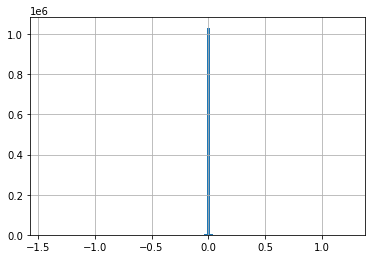

In [7]:
df['Vehicle_EKF_Theta'].hist(bins=100)

## Determining the road patch boundaries 

By plotting the histogram and the max, min of the vehicle coordinates

In [6]:
df['Local_X'].min()

0.879

In [7]:
df['Local_X'].max()

73.318

<AxesSubplot:>

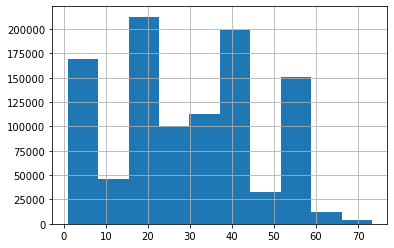

In [8]:
df['Local_X'].hist()

We see that the X of vehicles range from 0 to approximately 75ft.

<AxesSubplot:>

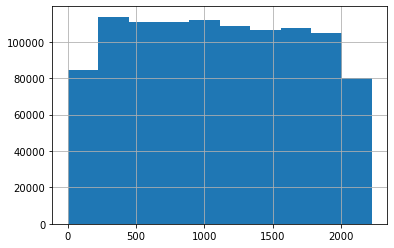

In [9]:
df['Local_Y'].hist()

In [10]:
df['Local_Y'].min()

0.0

In [11]:
df['Local_Y'].max()

2224.58

Similarly, for the Y coordinates, ranging from 0 to 2224.58ft.

## Generate a bunch of random trajectories inside the road patch

In [12]:
import pandas as pd
from ngsim_processor import NGSIM_Processor as NGSIM

if __name__ == '__main__':
    container_t = []
    container_x = []
    container_y = []
    num_of_trajs = 200
    traj_length = []

    df = pd.read_csv('kalmaned2.csv')
    ngsim = NGSIM(df)
    ngsim.set_patch(0.0, 75.0, 500.0, 750.0) # see the notebook df_stats.py to see where these numbers come from

    for i in range(num_of_trajs):
        t, x, y = ngsim.get_trajectory_random_in_patch()
        container_t.append(t)
        container_x.append(x)
        container_y.append(y)
        traj_length.append(len(t))
        if i%50 == 0:
            print('Trajectory {:d} generated, length {:d}'.format(i, len(t)))

    print('Process completed')


# See PyCharm help at https://www.jetbrains.com/help/pycharm/

NGSIM Processor is initialized
Trajectory 0 generated, length 117
Trajectory 50 generated, length 57
Trajectory 100 generated, length 83
Trajectory 150 generated, length 71
Process completed


Set all entrance time to zero

In [13]:
for i in range(num_of_trajs):
    container_t[i] -= container_t[i][0]

(array([ 2.,  0.,  0.,  7.,  5.,  5., 18., 13., 11., 15., 14.,  6.,  8.,
         7.,  8.,  6.,  6.,  5.,  3.,  1.,  7.,  3.,  4.,  2.,  0.,  0.,
         4.,  4.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,
         2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  2.,
         4.,  4.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  1.,  0.,  2.,  2.,  0.,  0.,  1.,  0.,  3.]),
 array([ 39.        ,  42.33333333,  45.66666667,  49.        ,
         52.33333333,  55.66666667,  59.        ,  62.33333333,
         65.66666667,  69.        ,  72.33333333,  75.66666667,
         79.        ,  82.33333333,  85.66666667,  89.        ,
         92.33333333,  95.66666667,  99.        , 102.33333333,
        105.66666667, 109.        , 112.33333333, 115.66666667,
        119.        , 122.33333333, 125.66666667, 129.        ,
        132.33333333, 135.66666667, 139.        , 142.33333333,
        145.66666667, 149.        , 152.33333333, 155.66666667,

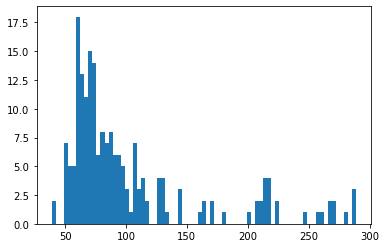

In [14]:
plt.hist(traj_length, bins=75)

From this distribution of trajectory length, it makes sense to extrapolate a little bit of trajectories to timestep 94, while trimming other longer trajectories to 94 timesteps. 

## Trim and lengthen trajectories

First, convert everything to numpy arrays

In [15]:
for i in range(num_of_trajs):
    container_t[i] = np.array(container_t[i])
    container_x[i] = np.array(container_x[i])
    container_y[i] = np.array(container_y[i])

In [16]:
from trim_and_lengthen import lengthen_trajectory_by_spline, trim_trajectory

In [17]:
median_traj_length = 51
new_t_vec = np.arange(0, median_traj_length * 100, 100)
container_x_new = container_x.copy()
container_y_new = container_y.copy()
for i in range(num_of_trajs):
    if traj_length[i] < median_traj_length:
        # Trajectory is shorter than median length, prolong the trajectory
        new_x_vec = lengthen_trajectory_by_spline(container_t[i], container_x[i], new_t_vec)
        new_y_vec = lengthen_trajectory_by_spline(container_t[i], container_y[i], new_t_vec)
        container_x_new[i] = new_x_vec
        container_y_new[i] = new_y_vec
    else:
        # Trajectory is equal or longer than the median length, trim the trajectory
        new_x_vec = trim_trajectory(container_t[i], container_x[i], new_t_vec)
        new_y_vec = trim_trajectory(container_t[i], container_y[i], new_t_vec)
        container_x_new[i] = new_x_vec
        container_y_new[i] = new_y_vec

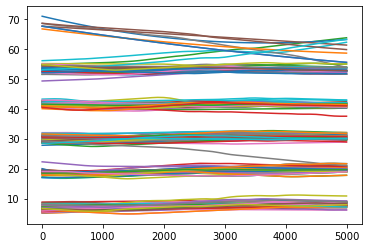

In [18]:
for i in range(num_of_trajs):
    plt.plot(new_t_vec, container_x_new[i])

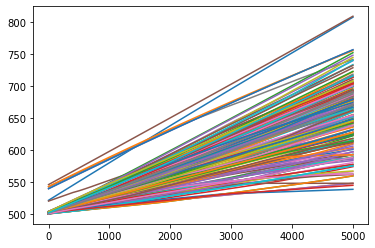

In [19]:
for i in range(num_of_trajs):
    plt.plot(new_t_vec, container_y_new[i])

## Offsetting the trajectory starting point to zero

In [20]:
for i in range(num_of_trajs):
    container_y_new[i] = container_y_new[i] - container_y_new[i][0]
    container_x_new[i] = container_x_new[i] - container_x_new[i][0]

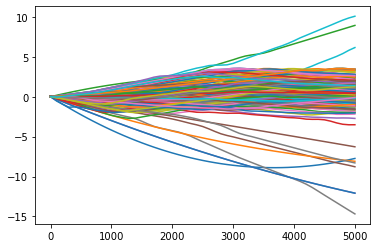

In [21]:
for i in range(num_of_trajs):
    plt.plot(new_t_vec, container_x_new[i])

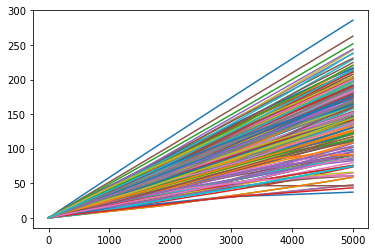

In [22]:
for i in range(num_of_trajs):
    plt.plot(new_t_vec, container_y_new[i])

## Save these trajectories into a file

In [23]:
import pickle

file_to_store = open("trajectories.pyo", "wb")
object_to_store = {
    't_vec': new_t_vec,
    'x_vec': container_x_new,
    'y_vec': container_y_new
}

pickle.dump(object_to_store, file_to_store)
file_to_store.close()

# FPCA decomposition and distribution learning

In [24]:
import sklearn
import skfda

In [25]:
fdgrx = skfda.FDataGrid(container_x_new, new_t_vec)
fdgry = skfda.FDataGrid(container_y_new, new_t_vec)

## FPCA decomposition for X component

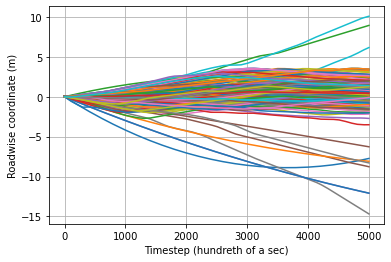

In [26]:
fdgrx.plot()
print('')
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')

In [27]:
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

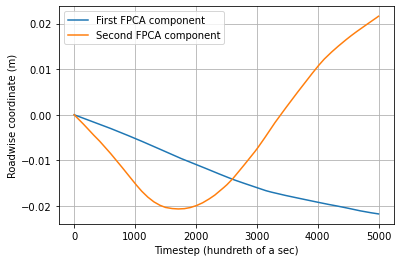

In [28]:
fpca_discretized_rw = FPCA(n_components=2)
fpca_discretized_rw.fit(fdgrx)
fpca_discretized_rw.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component'])
print('')

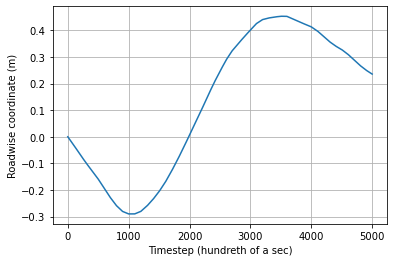

In [29]:
fpca_discretized_rw.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_curve = fpca_discretized_rw.mean_.data_matrix.reshape((-1))

In [30]:
fpca_discretized_rw.explained_variance_ratio_

array([0.93618661, 0.04570376])

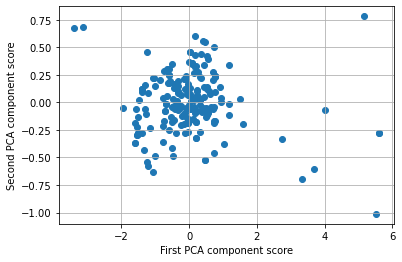

In [31]:
friendly_basis_rw = fpca_discretized_rw.components_.data_matrix.squeeze().transpose()
coeffs_rw = np.matmul(container_x_new - mean_curve, friendly_basis_rw)
plt.scatter(coeffs_rw[:,0], coeffs_rw[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

## FPCA with Y component

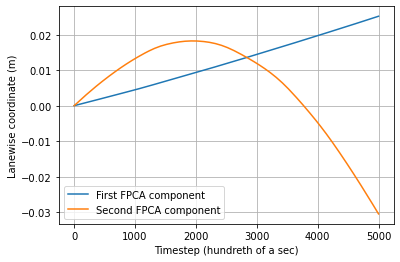

In [32]:
fpca_discretized_rw2 = FPCA(n_components=2)
fpca_discretized_rw2.fit(fdgry)
fpca_discretized_rw2.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Lanewise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component'])
print('')

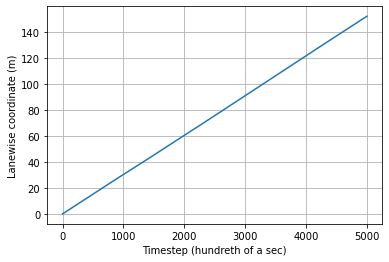

In [33]:
fpca_discretized_rw2.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Lanewise coordinate (m)')
plt.grid(True)
print('')
mean_curve2 = fpca_discretized_rw2.mean_.data_matrix.reshape((-1))

In [34]:
fpca_discretized_rw2.explained_variance_ratio_

array([0.99309338, 0.00618791])

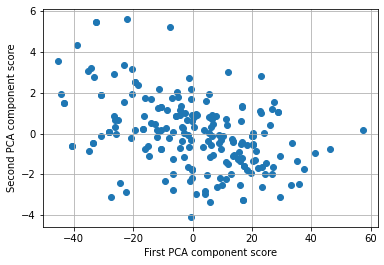

In [35]:
friendly_basis_rw2 = fpca_discretized_rw2.components_.data_matrix.squeeze().transpose()
coeffs_rw2 = np.matmul(container_y_new - mean_curve2, friendly_basis_rw2)
plt.scatter(coeffs_rw2[:,0], coeffs_rw2[:,1])
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

## Fitting a distribution onto the data

In [36]:
# Plotting helper function

import itertools
from scipy import linalg
import matplotlib as mpl
def plot_results(X, Y_, means, covariances, index, title):
    color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(X[:,0].min(), X[:,0].max())
    plt.ylim(X[:,1].min(), X[:,1].max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

In [37]:
from sklearn.mixture import GaussianMixture

Learning the X functionals (lanewise coordinate) distribution

In [38]:
gm_rw = GaussianMixture(n_components=1, random_state=0).fit(coeffs_rw)

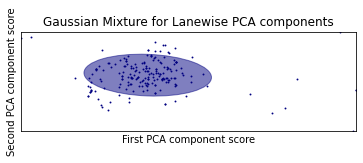

In [41]:
plot_results(coeffs_rw, gm_rw.predict(coeffs_rw), gm_rw.means_, gm_rw.covariances_, 0, 'Gaussian Mixture for Lanewise PCA components')
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

Learning the Y functionals (roadwise coordinate) distribution

In [40]:
gm_rw2 = GaussianMixture(n_components=1, random_state=0).fit(coeffs_rw2)

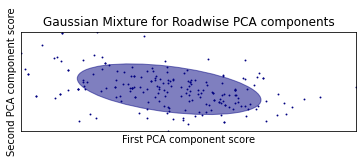

In [42]:
plot_results(coeffs_rw2, gm_rw2.predict(coeffs_rw), gm_rw2.means_, gm_rw2.covariances_, 0, 'Gaussian Mixture for Roadwise PCA components')
plt.xlabel('First PCA component score')
plt.ylabel('Second PCA component score')
plt.grid(True)

## Learned parameters

In [44]:
gm_rw.means_

array([[-4.77395901e-17, -1.38777878e-17]])

In [45]:
gm_rw.covariances_

array([[[ 1.46642423, -0.03537825],
        [-0.03537825,  0.07234044]]])

In [46]:
gm_rw2.means_

array([[4.79616347e-15, 7.58837437e-15]])

In [47]:
gm_rw2.covariances_

array([[[395.60982549, -14.82677746],
        [-14.82677746,   3.08518699]]])